In [3]:
import warnings
warnings.filterwarnings('ignore')

![](img/logo.png)

# Bagging y Random Forests

> __Alcance de la lectura__
> * Identificar el problema de la falta de generalización de los árboles.
> * Conocer la técnica de Bootstrap y su aplicación para Bagging
> * Implementar Bagging con `sklearn`.
> * Conocer el problema de árboles correlacionados producto de Bagging.
> * Conocer los Random Forests y cómo alivian el problema de árboles correlacionados.
> * Implementar Random Forests con `sklearn`


---

## Motivación


Resulta que hasta el momento nuestro flujo de trabajo conlleva evaluar múltiples modelos y posteriormente escoger el que tenga un mejor desempeño en los datos. Si bien este enfoque es intuitivo para nosotros, hay un par de contratiempos asociados:

1. Cuando implementamos un modelo en los datos, estamos ignorando deliberadamente todos los demás modelos candidatos que no son "lo suficientemente buenos". Estos clasificadores se conocen como __clasificadores debiles__ (_weak learners_, Kearns y Valliant, 1989), que se desempeñan marginalmente mejor que un clasificador aleatorio con chance $1/N_{\mathcal{Y}}$. Kearns y Valliant (1989) se preguntaron sobre qué tan válidos son los clasificadores débiles, y qué hacer frente a ellos. 
- Cuando elegimos un modelo dentro de una serie de candidatos, inevitablemente favoreciendo a un modelo con mayor sesgo o varianza. Este punto es extremadamente relevante en los árboles de decisión, donde se estima de forma local en los datos de entrenamiento.


Ante estas limitantes, el enfoque es agrupar modelos en lo que se conocen como __ensambles__. La intuición detrás de los ensambles es entrenar múltiples modelos de aprendizaje para resolver el mismo problema. Mediante la agrupación de múltiples clasificadores debiles potenciamos la capacidad de generalización, permitiendo que entre cada modelo exista colaboración y se potencien en su capacidad predictiva (Zhou, 2012). Existen dos grandes modos de ensamblar modelos: __paralelos__ y __secuenciales__. En esta lectura abordaremos los ensambles paralelos, específicamente Bagging y Random Forest.


## Bagging: Booststrap Aggregation


Consideremos una de las falencias principales de los árboles de decisión: dado que se optimizan de forma local en los datos de entrenamiento, pueden sufrir de alta varianza, disminuyendo su capacidad de generalización a datos previamente no vistos. Ya conocemos algunas estrategias dentro del modelo para aliviar este problema, como definir los criterios de partición, profundidad máxima de los nodos y cantidad de atributos a considerar en el modelo.

Leo Breiman (1984) sugirió otra alternativa: entrenar múltiples árboles de decisión con distintas muestras seleccionadas de forma aleatoria con reemplazo. Esta estrategia de aleatorizar se conoce como _bootstraping_. Es necesaria una pequeña digresión sobre ésta técnica:


> __Digresión__: Bootstrap
>
> Un problema clásico de la inferencia estadística es el hecho que mucho de sus métodos se apoyan en características asintóticas que guían hacia distribuciones normal y chi cuadrado.
> Una alternativa se proporciona mediante el bootstrap, que busca aproximar la distribución de un estadístico mediante simulación Monte Carlo con el muestreo realizado a partir de la distribución empírica o estimada de los datos observados. Este muestreo corresponde a un muestreo _con reemplazo_.
> La idea base del Bootstrap es generar inferencia __de una población a partir de una muestra__, que se puede obtener mediante el _remuestreo de la muestra_.



>###### Algorítmo básico de bootstrap
> 1. Dado datos $x_{i} \in \mathbf{x}$, extraer $N$ datos implementando un método definido y guardar los datos en una nueva muestra $x_{i}^* \in \mathbf{x^{*}}$.
> - Generar un estimando adecuado utilizando esta nueva muestra. 
> - Repetir $B$ veces los pasos 1 y 2, donde $B$ es un número grande. Con esto podremos obtener $B$ replicaciones del estimando de interés $\widehat{\theta^{*}} \in \widehat{\boldsymbol\theta}_{B}^{*}$.
> - Finalizada la iteración en $B$ estimar el nuevo estimandor con:
>
> - Estimandor puntual de la media:
$$
\bar{\widehat{\theta}^{*}} = \frac{1}{B}\sum_{b=1}^{B}\widehat{\theta}_{b}^{*}
$$
> - Estimandor puntual de la varianza:
$$
s^{2}_{\widehat{\theta}, \textsf{Bootstrap}} = \frac{1}{B - 1}\sum_{b=1}^{B}(\widehat{\theta}_{b}^{*} - \bar{\widehat{\theta}_{b}^{*}})^{2}
$$

Para ejemplificar su comportamiento, generaremos una simulación donde generamos un remuestreo de los datos disponibles. En la figura `afx.plot_bootstrap` comparamos la distribución teórica de una variable $X_{\textsf{pop}}\sim\textsf{Normal}(0, 1)$ con el comportamiento realizado en la cantidad de remuestros. En la práctica, si tenemos la información poblacional, el bootstraping no sería necesario.
Al generar distintas instancias sobre ésta distribución teórica, somos capaces de imitar su comportamiento, lo que nos permite asimilar características en la medida que remuestreamos todo el espacio de los datos.

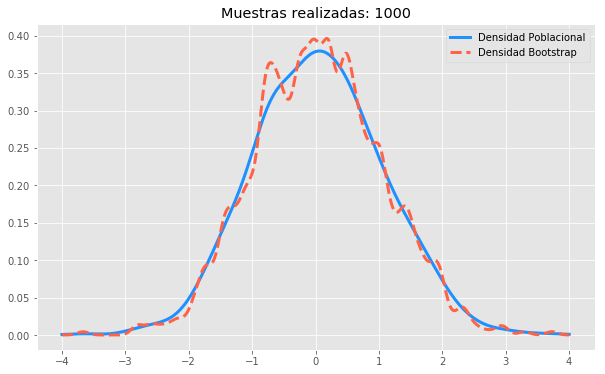

In [4]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import lec8_graphs as afx
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

afx.plot_bootstrap(n_sims=1000)

## Idea base de Bagging

El principal problema de un árbol es el hecho que puede sufrir de alta varianza en los datos de entrenamiento. Si bien técnicas como pruning puede reducir la varianza al eliminar nodos innecesarios, hay métodos alternativos que se benefician del overfit producto de los árboles.

Bagging combina y promedia múltiples modelos. Mediante la ponderación de múltiples árboles se contrarrestra la variabilidad de cualquier árbol y reduce el overfit, mejorando su capacidad predictiva.

### Pasos

Los pasos para implementar Bagging se puede entender como:

1. Crear $M$ muestras mediante _bootstrap_ de la muestra de entrenamiento. Con este proceso, generamos distintos subconjuntos de datos que compartirán una distribución similar a la muestra de entrenamiento.
- Dentro de cada muestra $m \in M$, se entrena un árbol donde sus nodos crecen al máximo.
- Para una observación previamente no observada, se promedian las predicciones _de cada árbol_ para crear un valor promedio global.

Cabe destacar que éste procedimiento es agnóstico a la implementación. Podríamos implementarlo en modelos de regresión y sus variantes, pero resulta que su mejor desempeño es cuando incorporamos datos donde los modelos sufren de alta varianza. Resulta que Bagging es una estrategia generalizable a múltiples modelos, orientada a la reducción de la varianza mediante la repetición del entrenamiento en múltiples muestras. Si bien se puede aplicar en contextos como regresiones, es en los árboles donde tiene un mejor desempeño dado que estabiliza la predicción en múltiples instancias.


Si tomamos un clasificador binario débil que busca asignar clases en el vector objetivo $\mathcal{Y} = \{-1, 1\}$, y entrenamos un modelo representado con $h_{t}(x)$, éste tendrá un error de generalización en nuevas observaciones de $\varepsilon_{y}$. El error de generalización en el modelo específico será la probabilidad de no ocurrencia en otro modelo $\textsf{Pr}(h_{t}(\mathbf{x}) \neq f(\mathbf{x}))$. 

Mediante Bagging podemos sumar y promediar cada uno de los clasificadores binarios débiles con:

$$
\mathcal{H}(\mathbf{x}) = \textsf{sign}\big(\sum_{t=1}^{T}h_{t}(\mathbf{x})\big)
$$

donde $T$ es la cantidad de modelos entrenados. Para cada una de las observaciones en la muestra de entrenamiento, sumamos la clase predicha en cada modelo. El ensamble $\mathcal{H}$ generará un error sólo cuando la mitad o más de los clasificadores débiles $t \in T$ generen un error.

Otra de las ventajas de implementar bootstraping en el proceso de Bagging es atenuar la dependencia entre clasificadores débiles. Dado que todos son generados en base a la misma muestra de entrenamiento, el modelo estará aprendiendo éstos datos en una tasa muy rápida. Mediante bootstrap generamos muestras donde ignoraremos ciertas observaciones, induciendo aleatoriedad en el proceso de entrenamiento del modelo.

Uno de los beneficios de bagging es que en promedio una muestra creada con bootstrap contendrá un $.63$ de la muestra de entrenamiento. Esto nos deja con un $.33$ de los datos que se encontrarán fuera de la muestra. Esta cifra se conoce como el _out-of-bag-sample_ para estimar el error __en la muestra de validación__. Este punto confiere una característica deseable de Bagging: En la medida que aumentamos la cantidad de muestras generadas con bootstrap, podemos implementar la _out-of-bag-sample_ para estimar la exactitud del modelo en sus predicciones, conllevando a un proceso similar a la validación cruzada. Revisitaremos esta idea cuando posteriormente en esta lectura con los Random Forest.

### Implementando Bagging para los Precios de California

Para ejemplificar el uso de Bagging, utilizaremos la base de datos sobre los precios de inmuebles en California utilizada en el ejemplo de Árboles de Decisión. Esto nos permitirá realizar comparaciones respecto al comportamiento de ambos modelos. Partamos por implementar el mismo preprocesamiento de datos.

In [5]:
import pandas as pd
df = pd.read_csv('cadata.csv', header=1).drop(columns='1')

In [6]:
df['log_MedianIncome'] = np.log(df['MedianIncome'])
df['log_MedianHouseValue'] = np.log(df['MedianHouseValue'])
df = df.drop(columns=['MedianHouseValue', 'MedianIncome'])

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'MedianHouseAge':'log_MedianIncome'],
                                                   df['log_MedianHouseValue'],
                                                   test_size=.33, random_state=11238)

Para implementar Bagging con árboles de regresión, debemos incorporar la clase `sklearn.ensemble.BaggingRegressor`. Dado que en ésta implementación utilizaremos árboles de regresión que vienen por defecto implementados en la clase, no es necesario especificar sobre el comportamiento de hiperparámetros todavía, con la salvedad de implementar una semilla, para asegurar la replicación de resultados.


> __Digresión__: `sklearn.ensemble.BaggingRegressor/BaggingClassifier`
>
> La API es generalizable, por defecto implementa árboles pero se puede incorporar cualquier modelo que forme parte de `scikit-learn`. Resulta que la implementación se realiza en consideración al efecto reductor de varianza, haciéndolo un procedimiento fuertemente asociado con los árboles de decisión.

Si implementamos nuestro modelo sin modificar hiperparámetros, la clase `BaggingRegressor` generará 10 modelos. Como todo modelo de `scikit-learn`, para entrenarlo necesitamos utilizar el método `fit`

In [8]:
from sklearn.ensemble import BaggingRegressor
bagging_model = BaggingRegressor(random_state=11238).fit(X_train, y_train)

Partamos por examinar cada uno de los árboles. Éstos se encuentran dentro del modelo en `BaggingRegressor.estimators_`. Vamos a solicitar la información sobre el tipo de modelo, el criterio y la semilla pseudoaleatoria asociada a cada uno de ellos. Observamos que por defecto implementa modelos `sklearn.tree.tree.DecisionTreeRegressor`, con el criterio de optimización `'mse'` y una semilla que varía entre cada uno de ellos.

In [9]:
for i in bagging_model.estimators_:
    print("Modelo: {}. Criterio: {}. Semilla: {}".format(type(i), i.criterion,i.random_state))

Modelo: <class 'sklearn.tree.tree.DecisionTreeRegressor'>. Criterio: mse. Semilla: 134534932
Modelo: <class 'sklearn.tree.tree.DecisionTreeRegressor'>. Criterio: mse. Semilla: 1532576145
Modelo: <class 'sklearn.tree.tree.DecisionTreeRegressor'>. Criterio: mse. Semilla: 1982095898
Modelo: <class 'sklearn.tree.tree.DecisionTreeRegressor'>. Criterio: mse. Semilla: 280845846
Modelo: <class 'sklearn.tree.tree.DecisionTreeRegressor'>. Criterio: mse. Semilla: 1572358144
Modelo: <class 'sklearn.tree.tree.DecisionTreeRegressor'>. Criterio: mse. Semilla: 198602398
Modelo: <class 'sklearn.tree.tree.DecisionTreeRegressor'>. Criterio: mse. Semilla: 120741769
Modelo: <class 'sklearn.tree.tree.DecisionTreeRegressor'>. Criterio: mse. Semilla: 860188809
Modelo: <class 'sklearn.tree.tree.DecisionTreeRegressor'>. Criterio: mse. Semilla: 2093968571
Modelo: <class 'sklearn.tree.tree.DecisionTreeRegressor'>. Criterio: mse. Semilla: 1518121755


Ahora evaluemos el desempeño del ensamble Bagging con las métricas `mean_squared_error` y `r2_score`. Para ello tomemos en cuenta que el desempeño del árbol de decisión que implementamos en la lectura anterior era el siguiente:

| Métrica | Valor| 
|---------|------|
|   MSE   | 0.109 |
|   MAE   | 0.157 | 
| $R^2$   | 0.668 |

Observamos que simplemente con 10 árboles promediados, nuestro error cuadrático promedio disminuyó en 0.049, la mediana absoluta del error disminuyó en 0.034 y el coeficiente de determinación aumento en .147. 

In [10]:
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

print("MSE:", mean_squared_error(y_test, bagging_model.predict(X_test)))
print("MAE:", median_absolute_error(y_test, bagging_model.predict(X_test)))
print("R2:", r2_score(y_test, bagging_model.predict(X_test)))


MSE: 0.061222886360262886
MAE: 0.12350275623793827
R2: 0.8140554948794472


## Inspeccionando las predicciones

Ya sabemos cómo se comporta la clase `sklearn.ensemble.BaggingRegressor` a grandes rasgos. Ahora ejemplificaremos cómo se genera el proceso de predicción para una observación específica en el testing set.

La observación que tenemos corresponde a las siguientes características

In [11]:
X_test[:1]

,MedianHouseAge,TotalRooms,TotalBedrooms,Population,Households,Latitude,Longitude,log_MedianIncome
16934,9.0,1150.0,287.0,377.0,243.0,37.56,-122.32,1.343309


Su valor verdadero en el vector objetivo es de:

In [12]:
y_test[:1]

16934    12.377923
Name: log_MedianHouseValue, dtype: float64

Lo que necesitamos hacer generar una predicción de ésta observación en cada árbol de regresión entrenado en nuestro ensamble de Bagging. Para ello implementaremos la siguiente comprensión de lista:

In [13]:
hold_instance = [i.predict(X_test[:1]) for i in bagging_model.estimators_]

Para facilitar el proceso de visualización, generaremos un eje X con las etiquetas pertinentes a cada árbol.

In [14]:
dec_tree_lab = ["RegressionTree: {}".format(i + 1) for i in range(len(bagging_model.estimators_))]

Cada punto azul en la figura creada corresponde a la predicción realizada por un árbol en específico. La recta roja representa la predicción promediada del ensamble con Bagging. La predicción del modelo toma en consideración cada uno de los puntos específicos. 

Retomemos nuestros conocimientos básicos de estadística. Resulta que en la medida que nuestro ensamble de Bagging aumenta la cantidad de estimadores entrenados, estaremos recabando más información sobre el parámetro poblacional a inferir. Esta es una aplicación de la ley de los grandes números.

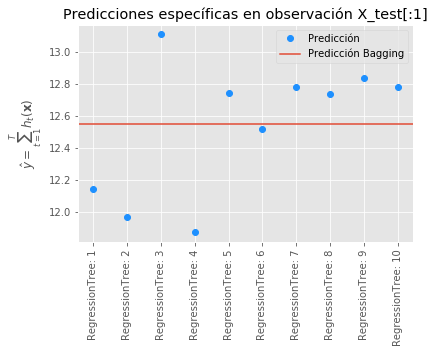

In [15]:
plt.plot(hold_instance, 'o', color='dodgerblue', label='Predicción')
plt.xticks(range(10), dec_tree_lab,rotation =90)
plt.axhline(bagging_model.predict(X_test[:1]), label='Predicción Bagging')
plt.ylabel(r'$\hat{y} = \sum_{t=1}^{T} h_{t}(\mathbf{x})$')
plt.title('Predicciones específicas en observación X_test[:1]')
plt.legend();

## Efecto de la cantidad de modelos incorporados en el ensamble

Sigamos expandiendo la idea del comportamiento asintótico de los ensambles. Resulta que este comportamiento también es válido cuando nos referimos al desempeño general del modelo. Consideremos el siguiente experimiento: Vamos a entrenar 40 modelos con nuestro regresor Bagging, donde incrementaremos en pasos de 25 la cantidad de estimadores incluídos, hasta llegar a aproximadamente 1000.

In [16]:
# generamos 3 listas para guardar resultados
tmp_mse_test, tmp_mae_test, tmp_r2_test = [], [], []

# generamos valores a pasar
n_tree = range(20, 1000, 50)

# Para cada uno de los rangos declarados
for i in n_tree:
    # Entrenamos nuestro modelo
    tmp_bag_model = BaggingRegressor(n_estimators=i, random_state=11238).fit(X_train,y_train)
    # guardamos el mse
    tmp_mse_test.append(mean_squared_error(y_test, tmp_bag_model.predict(X_test)))
    # guardamos el mae
    tmp_mae_test.append(median_absolute_error(y_test, tmp_bag_model.predict(X_test)))
    # guardamos el rcuadrado
    tmp_r2_test.append(r2_score(y_test, tmp_bag_model.predict(X_test)))

Graficando los resultados del modelo evaluado en distintos puntos, se aprecia que en los primeros árboles evaluados, la mejora en el desempeño es substancial en sus primeras iteraciones. Los criterios $R^{2}$ y error cuadrático promedio se comportan relativamente similar: a partir de los 500 estimadores, el desempeño se estabilizará.

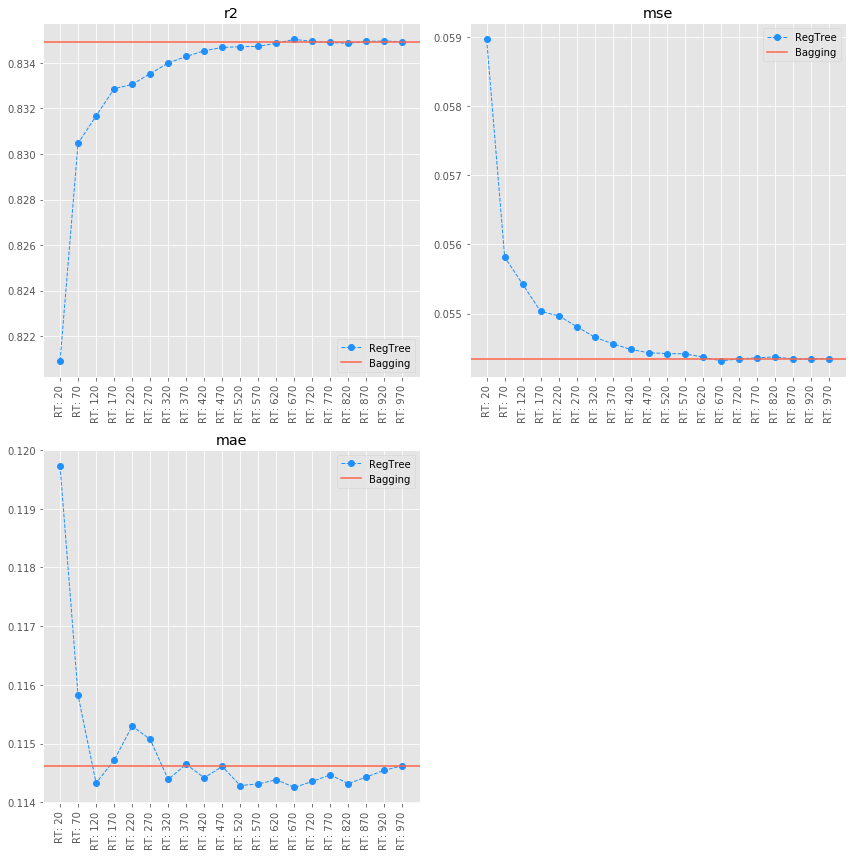

In [17]:
params = [[1, tmp_r2_test, 
           r2_score(y_test, tmp_bag_model.predict(X_test)), 'r2'],
          [2, tmp_mse_test, 
           mean_squared_error(y_test, tmp_bag_model.predict(X_test)), 'mse'],
          [3, tmp_mae_test, 
           median_absolute_error(y_test, tmp_bag_model.predict(X_test)), 'mae']]


plt.figure(figsize=(12, 12))
for i in params:
    plt.subplot(2, 2, i[0])
    afx.plot_bagging_behavior(i[1], i[2], n_tree)
    plt.title(str(i[3]))
    plt.tight_layout()

### Probando la correlación entre árboles

Los clasificadores débiles deben ser __diversos__, esto quiere decir que la correlación entre las predicciones de dos árboles deben ser bajas. Implementando nuestro primer modelo con 10 estimadores, las correlaciones bivariadas entre los puntajes predichos de cada árbol son lo suficientemente fuertes como para levantar sospechas. Esto es problemático dado que nuestro modelo de ensamble estará siendo entrenado con información repetida. Para evaluar la correlación entre cada uno de los árboles, generaremos las predicciones de cada uno de los árboles y posteriormente las correlacionaremos.

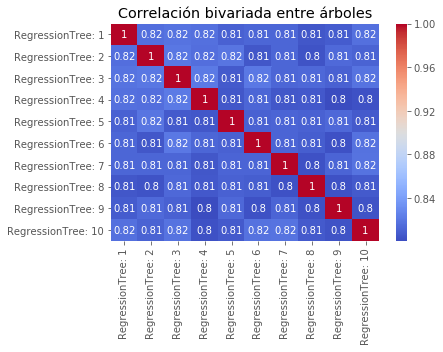

In [18]:
from scipy import stats
import seaborn as sns

store_rho = []

"""
Guardamos los estimadores de nuestro
primer modelo.
"""
bag_est = bagging_model.estimators_

# recorremos dos veces los estimadores
for i in bag_est:
    for j in bag_est:
        # y calculamos las correlaciones entre pares
#         model_1_error = (1 - mean_squared_error(y_test, i.predict(X_test)))
#         model_2_error = (1 - mean_squared_error(y_test, j.predict(X_test)))
        store_rho.append(stats.pearsonr(i.predict(X_test), j.predict(X_test))[0])
#         store_rho.append(stats.pearsonr(model_1_error, model_2_error))
store_rho = np.array(store_rho).reshape(len(bag_est), len(bag_est))

sns.heatmap(store_rho, cmap='coolwarm', annot=True, xticklabels=dec_tree_lab,
            yticklabels=dec_tree_lab);

plt.title("Correlación bivariada entre árboles");

El heatmap de arriba muestra evidencia a favor de la existencia de árboles correlacionados. Esta es la principal piedra de tope de Bagging, y que da paso para hablar de su siguiente iteración: __Random Forest__.

# Random Forests (Bosques aleatorios)

Para solucionar el problema de clasificadores débiles correlacionados entre sí, Breiman (2001) diseñó los Random Forests. Éstos se pueden entender como una extensión de un ensamble Bagging. De manera similar a éstos, se genera un conjunto finito de submuestras con reemplazo mediante Bootstrap. Para resolver el problema de correlación entre clasificadores, se incluye un mecanismo aleatorio de selección de atributos. Durante la construcción de árboles, Random Forests selecciona un subconjunto de atributos de manera aleatoria y prosigue de igual manera con el entrenamiento y selección de particiones. Dado que con bagging __contamos todos los atributos__ en cada árbol, Random Forest agrega más aleatoriedad en el proceso de crecimiento de los árboles.

Los Random Forests dependen de un parámetro $K$ que controla la incorporación de aleatoriedad. Cuando $K=\#\textsf{Atributos}$, el árbol construído es idéntico a un proceso determinístico. Cuando $K=1$, el árbol construído tendrá un atributo escogido al azar. Breiman (2001) sugiere que un buen valor es $K=\textsf{log}(\#\textsf{Atributos})$. Cabe señalar que la aleatorización se induce en la selección de atributos, no en la selección de divisiones para el conjunto de atributos.

Tienen un peor punto de inicio aleatorio, pero converge a tasas de error bajas en menor cantidad de iteraciones, en comparación a otros modelos. En la etapa de entrenamiento es más eficiente que un ensamble Bagging, dado que implementa árboles aleatorios que necesitan sólo del subconjunto de atributos en oposición a Bagging donde se deben incluír todos.


### Pasos para construír un Random Forest

1. Fijar la cantidad de árboles a construír.
- Para cada árbol a construír:
    - Generamos una muestra con boostrap.
    - Hacemos crecer un árbol en ésta.
    - Para cada split existente:
        - Seleccionamos j variables de manera aleatoria de $\mathcal{J}$.
        - Seleccionamos el mejor punto de corte entre las variables j.
        - Particionamos el nodo en dos. 

### Digresión: La receta para cocinar un buen ensemble

> Al igual que hoy en día pasa con los modelos basados en redes neuronales, mucho esfuerzo se puso en algún momento en el desarrollo de métodos de ensamblado ya que aportaron un gran salto en efectividad a partir de los modelos clásicos. Random Forest no es el único método de ensablado ni mucho menos el "mejor", existen otros modelos que pueden llegar a presentar tanta o mejor efectividad que RF, pero, ¿En qué se diferencian todos estos métodos entre sí?, para responder esta pregunta, veamos en qué se parecen.
>
>Como mencionamos, un método de ensamblado combina una serie de máquinas para conformar una sola máquina:
>$$
F = \Sigma^{N}_{i} w_{i}\cdot f_{i}
$$
>
> $F$ es la máquina de ensablado, a $f_{i}$ se le conoce como __*Learner Base*__, es la máquina básica con la cual se construye el ensemble, en el caso de RF el learner base es un árbol de clasificación. Por otro lado, $w_{i}$ representa la *"importancia"* que se le dará a una determinada máquina $F_{i}$ dentro del contexto del ensemble.
>
>Bajo esta definición podemos juntar cualquier conjunto de máquinas que nos gusten y armar un gran monstruo de Frankenstein. Lamentablemente esta aproximación no nos asegura obtener un buen ensemble, la clave de la receta está en __inyectar diversidad__. Podemos inyectar diversidad de diversas formas (pun intended), para esto se puede variar el learner base, manipular directamente los datos (distintos conjuntos de entrenamiento) o incluso variar los hiperparámetros.
>
> En el proceso de manipular los datos, podemos particionar horizontalmente o verticalmente (feature selection). RF implementa ambas, particiona horizontalmente al utilizar distintas muestras bootstrap para entrenar los distintos learner base y al mismo tiempo particiona verticalmente implementando la selección aleatoria de atributos con los que se entrenará a cada learner base.

## Out-Of-Bag 

Con los modelos anteriores, estabamos acostumbrados a implementar validación cruzada para escoger de mejor manera los hiperparámetros y mejorar nuestra capacidad predictiva. El problema con Bagging y Random Forest es que implementar la validación cruzada puede ser bastante costoso en términos computacionales. Dado que en cada paso de validación cruzada estamos construyendo $K \times n\_estimators$. Una de las ventajas de los Random Forests es que devuelve un error "fuera de la bolsa". 

Dado esta característica de los datos provista mediante boostrap, la bondad de los clasificadores se puede estimar a partir de éstos datos ignorados en cada instancia del modelo. Esto se conoce como la muestra _out-of-bag_ (OOB, de aquí en adelante, y nos permite generar una aproximación a la tasa de errores con validación cruzada. 

Para cada observación $z_{i} - (x_{i} - y_{i})$, construír un predictor con random forest  mediante el promedio de aquellos árboles con muestras de bootstrap en donde $z_{i}$ __no aparezca__. Un error estimado _out-of-bag_ tendrá un comportamiento idéntico al obtenido con una validación cruzada N fold. Esta es una ventaja de RF por sobre otros algoritmos, dado que se implementa la validación cruzada en el mismo tiempo en que el modelo se ejecuta (Hastie et al., 2009).

Para obtener el estimador OOB, necesitamos registrar los ejemplos de entrenamiento implementados en cada instancia de clasificador débil. La predicción OOB de las observaciones no entrenados con $\mathbf{x}$ se obtiene a partir de:

$$
\mathcal{H}^{\textsf{out-of-bag}}(\mathbf{x}) = \underset{y \in \mathcal{Y}}{\textsf{argmax}}\sum_{t=1}^{T}I(h_{t}(\mathbf{x})= y) \cdot \mathbb{I}(\mathbf{x} \notin D_{t})
$$

A partir de esta predicción se puede obtener el error de generalización asociado a Bagging/Random Forest

$$
\varepsilon^{\textsf{out-of-bag}} = \frac{1}{\vert \textsf{Datos} \vert} \sum_{\mathbf{x, y} \in \textsf{Datos}} I(\textsf{H}^{\textsf{out-of-bag}} (\mathbf{x} \neq y)
$$


Dado que cada árbol se construye a partir de una muestra realizada con bootstrap, para cada árbol existe una porción de los datos no se utiliza con la cual podemos estimar qué tan bueno es nuestra estimación.


## Implementación de Random Forest para la clasificación de votos

Para exponer la implementación de un algoritmo Random Forest, utilizaremos los datos en el archivo `voting.csv` de la lectura de Árboles de Clasificación. Implementaremos el mismo proceso de preprocesamiento y selección de atributos que cuando implementamos el modelo `DecisionTreeClassifier`.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [20]:
df = pd.read_csv('voting.csv').drop(columns='Unnamed: 0')
# Vamos a binarizar cada variable categórica, ignorando la primera categoría de referencia
# Región del país
df = pd.concat([df, pd.get_dummies(df['region'], drop_first=True, prefix='region')], axis=1)
# Nivel educacional del encuestado
df = pd.concat([df, pd.get_dummies(df['education'], drop_first=True, prefix='ed')], axis=1)
# Sexo del encuestado
df = pd.concat([df, pd.get_dummies(df['sex'], drop_first=True, prefix='sex')], axis=1)
# Intención de voto
df = pd.concat([df, pd.get_dummies(df['vote'], drop_first=False, prefix='vote')], axis=1)
# Botamos las variables originales
df = df.drop(columns=['region', 'sex', 'education', 'vote'])
df.head()
# Nos aseguramos de limpiar los datos perdidos
df = df.dropna()

# generamos las muestras definiendo la matriz de atributos
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'population':'ed_S'],
                                                    # el vector objetivo
                                                    df['vote_N'],
                                                    # el tamaño de la muestra a dejar como validación
                                                    test_size=.33,
                                                    # definiendo la semilla pseudoaleatoria
                                                    random_state=11238)


Para implementar un Random Forest para un problema de clasificación, debemos incorporar la clase `sklearn.ensemble.RandomForestClassifier`. 

> __Digresión__: Implementación de Random Forest
>
> Resulta que la implementación original de Random Forest diseñada por Breiman (2001) dista de la implementación en `scikit-learn`. En la implementación de Breiman, cada clasificador __debe__ votar por una clase específica. mientras que la implementación de `scikit-learn` promedia la predicción probabilística de cada clasificador __antes__ de asignar la clase.
> La implementación similar a Breiman en `scikit-learn` corresponde a `VotingClassifier`.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

Anteriormente hablamos de las virtudes de la muestra _out-of-bag_. Para solicitarla en nuestro ensamble de Random Forest, necesitamos declarar la opción `oob_score=True`, que permitirá registrar el efecto predictivo de cada modelo dentro del ensamble en la muestra que no fue incluída dentro del bootstrap.

In [22]:
voting_rf = RandomForestClassifier(oob_score=True, random_state=11238).fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Si implementamos el modelo con la cantidad por defecto de estimadores (`n_estimators=10`), `sklearn` advertirá que algunos modelos no tienen puntajes OOB dado que existen muy pocos árboles como para estimar OOB de forma confiable.

Probablemente dado el desbalance entre clases de nuestro vector objetivo, el modelo tiene un peor desempeño en identificar correctamente aquellos casos donde se votó que no.

In [23]:
print(classification_report(y_test, voting_rf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.83      0.89      0.86       572
          1       0.75      0.64      0.69       283

avg / total       0.81      0.81      0.81       855



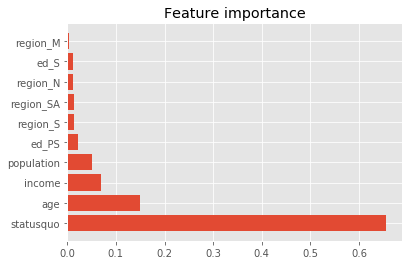

In [24]:
import lec8_graphs as afx
voting_rf.feature_importances_
x_mat_vars = df.loc[:, 'population':'ed_S']
afx.plot_importance(voting_rf, x_mat_vars.columns)

## Visualizando el efecto de múltiples árboles en la clasificación

Refinemos el modelo mediante la separación de los dos atributos con una mayor importancia relativa en la definición de cortes. Estos son `statusquo` y `age`. Al visualizar las observaciones condicional al vector objetivo, encontramos que aquellos que votaría no en el Plebiscito se posicionan en valores negativos, mientras que el efecto de la edad parece ser constante. Existe una superposición entre observaciones que impide el buen funcionamiento de un clasificador lineal.


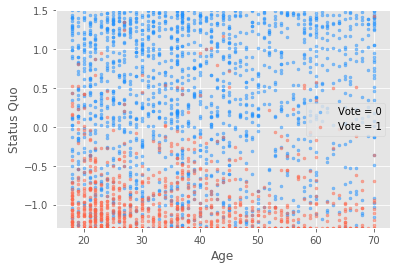

In [25]:
depured_X = df.loc[:, ['age', 'statusquo', 'vote_N']]
colors = ['dodgerblue', 'tomato']
for i in depured_X['vote_N'].unique():
    plt.scatter(depured_X[depured_X['vote_N'] == i]['age'],
                depured_X[depured_X['vote_N'] == i]['statusquo'],  marker='.', 
               label="Vote = {}".format(i), alpha=.5, color=colors[i])
plt.legend();
plt.ylim(-1.3, 1.5);
plt.ylabel('Status Quo');
plt.xlabel('Age');

Para efectos prácticos, entrenaremos un Random Forest con 500 árboles en la muestra completa, de manera tal de ver cómo se comporta el clasificador.

In [26]:
random_forest = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=11238,oob_score=True)
random_forest.fit(depured_X.loc[:, 'age':'statusquo'], depured_X['vote_N'])
get_x_1 = afx.fetch_lims(depured_X['statusquo'])
get_x_2 = afx.fetch_lims(depured_X['age'])
x_mesh, y_mesh, joint_xy = afx.generate_mesh_grid(depured_X, 'age', 'statusquo')
Z = random_forest.predict_proba(np.c_[x_mesh.ravel(), y_mesh.ravel()])[:, 1].reshape(x_mesh.shape)

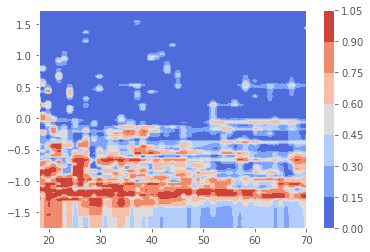

In [27]:
plt.contourf(x_mesh, y_mesh, Z, cmap='coolwarm')
plt.colorbar()

La superficie de respuesta inferida en el modelo mapea de forma eficiente la probabilidad de votar No, permitiendo separar aquellas observaciones que se escapan de la norma.

### Incorporación de aleatoriedad en los atributos

Anteriormente se mencionó una de las principales características sobre los Random Forest: la capacidad de inducir aleatoridad en la cantidad de atributos agregados. En la clase `sklearn.ensemble.RandomForestClassifier`, el hiperparámetro se controla con la opción `max_features`. Las opciones disponibles son:

- Un número entero que fija la cantidad de atributos en cada estimador.
- Un número flotante que considera una fracción de los atributos mediante `int(max_features * n_features)`.
- `auto` y `sqrt` conllevan a la misma estrategia, donde la cantidad de atributos se escoje con $\sqrt{\textsf{n_atributos}}$. Esta es la opción por defecto.
- `log2`, la cantidad de atributos se escoje con $\textsf{log}_{2}(\textsf{n_atributos})$.
- `None`, la cantidad de atributos máximos corresponde a la cantidad de atributos total en la matriz. Esta situación es idéntica a un algoritmo de ensamble Bagging.

Breiman (2001) sugiere que un buen valor por defecto para escoger la cantidad de atributos a aleatorizar es mediante el logaritmo. Para ejemplificar el efecto de la aleatorización de los atributos en los modelos, evaluaremos el desempeño de cada criterio de selección condicional a una serie de estimadores. El código presentado abajo registará los puntajes OOB y exactitud (medidos como el error, siguiendo las prácticas de Hastie et al. (2009)).

In [28]:
# generamos una serie de listas para guardar los valores
tmp_oob_none, tmp_oob_sqrt,tmp_oob_log2 = [], [], []
tmp_test_acc_none, tmp_test_acc_sqrt, tmp_test_acc_log = [], [], []
n_estimators = range(20, 1000, 500)

In [29]:
# para cada rango de modelos estimados
for i in n_estimators:
    # Implementamos una variante con todos los atributos
    voting_rf_none = RandomForestClassifier(n_estimators= i,max_features=None,
                                       oob_score=True,
                                       random_state=123).fit(X_train, y_train)
    # Implementamos una variante donde los atributos se escogen con sqrt
    voting_rf_sqrt = RandomForestClassifier(n_estimators= i, max_features="sqrt",
                               warm_start=True,
                               oob_score=True,
                               random_state=123).fit(X_train, y_train)
    # Implementamos una variante donde los atributos se escogen con log
    voting_rf_log = RandomForestClassifier(n_estimators= i, max_features="log2",
                               warm_start=True,
                               oob_score=True,
                               random_state=123).fit(X_train, y_train)
    # Estimamos el error en OOB
    tmp_oob_none.append(1 - voting_rf_none.oob_score_)
    tmp_oob_sqrt.append(1 - voting_rf_sqrt.oob_score_)
    tmp_oob_log2.append(1 - voting_rf_log.oob_score_)
    # Estimamos el error en la exactitud
    tmp_test_acc_none.append(1 - accuracy_score(y_test, voting_rf_none.predict(X_test)))
    tmp_test_acc_sqrt.append(1 - accuracy_score(y_test, voting_rf_sqrt.predict(X_test)))
    tmp_test_acc_log.append(1 - accuracy_score(y_test, voting_rf_log.predict(X_test)))


El primer punto a destacar en la figura, es que el no aleatorizar los atributos en cada modelo del ensamble genera un peor desempeño tanto en puntaje OOB y error en la muestra de validación. El segundo punto a considerar es que para este problema el desempeño es idéntico al implementar un criterio de aleatorización de atributos log o sqrt. Un tercer elemento a considerar es el hecho que el comportamiento del puntaje _OOB_ tiende a mejorar en la medida que aumentamos la cantidad de estimadores a incluír en el ensamble.

<Figure size 864x288 with 0 Axes>

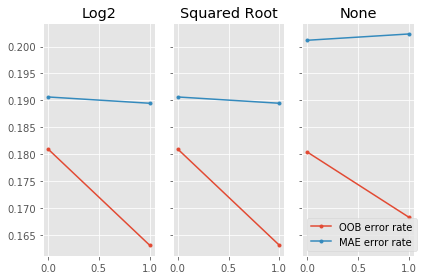

In [30]:
plt.figure(figsize=(12, 4));
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True);
axs[0].plot(tmp_oob_log2, '.-', label='OOB error rate');
axs[0].plot(tmp_test_acc_log, '.-', label='MAE error rate');
axs[0].set_title('Log2');
axs[1].plot(tmp_oob_sqrt,'.-',  label='OOB error rate');
axs[1].plot(tmp_test_acc_sqrt,'.-',  label='MAE error rate');
axs[1].set_title('Squared Root');
axs[2].plot(tmp_oob_none, '.-', label='OOB error rate');
axs[2].plot(tmp_test_acc_none,'.-',  label='MAE error rate');
axs[2].set_title('None');
plt.tight_layout();
plt.legend();


## Aspectos adicionales a considerar

### Pros

* Si bien Bagging se considera un punto procedimental para entender el comportamiento de Random Forests,  las clases `sklearn.ensemble.BaggingRegressor` y `sklearn.ensemble.BaggingClassifier` funcionan como wrappers: métodos que nos permiten flexibilizar los modelos a ingresar. 
*  Por lo general estos modelos tienen un buen desempeño "out-of-the-box", dado que no hay mucho hiperparámetro a modificar que afecte a la forma funcional del modelo (a diferencia de Support Vector MachineS). Todos los hiperparámetros tiene propiedades asintóticas.
* Dado que se itera una serie de veces, tienen un método de validación cruzada sin la necesidad de envolverlo en un `sklearn.model_selection.GridSearchCV`.
* Como se basan en árboles, no es necesario preprocesamiento alguno y son robustos a casos atípicos.

### Cons

* Random Forest tiene una baja interpretabilidad, obfuscada por la selección de atributos aleatorizada.
* Tiene una complejidad substancial dependiente de la cantidad de datos.


## Referencias

* Breiman, Leo. 2001. Random Forests.
* Zhou, 2012. Ensembles Methods. Foundations and Algorithms.
* Hastie, T; Tibshirani, R; Friedman, J. 2009. The Elements of Statistical Learning.
* Kearns y Valliant. 1989. Cryptographic limitations on Learning Boolean Formulae and Finite Automata.
